🔍 DEBUG suggest_all_params - Parámetros generados:
🔍   CatBoost params: ['cat_main_iterations', 'cat_main_depth', 'cat_main_learning_rate', 'cat_main_l2_leaf_reg', 'cat_main_early_stopping', 'cat_meta_iterations', 'cat_meta_depth', 'cat_meta_learning_rate', 'cat_meta_l2_leaf_reg', 'cat_meta_early_stopping']
🔍   Feature params: ['feature_main_periods', 'feature_main_stats', 'feature_meta_periods', 'feature_meta_stats']
🔍   Label params: ['label_markup', 'label_min_val', 'label_max_val', 'label_atr_period', 'label_method_random']
🔍   Algo params: ['meta_threshold', 'oof_resid_percentile', 'main_threshold']
🔍   Total params: 22
🔍 DEBUG search_reliability - Parámetros de confiabilidad: {'label_markup': 0.2190569252816092, 'label_min_val': 7, 'label_max_val': 30, 'label_atr_period': 27, 'label_method_random': 'random'}
🔍 DEBUG: base_df.shape = (32877, 5)
🔍 DEBUG: train_start = 2020-02-01 00:00:00, train_end = 2025-02-01 00:00:00
🔍 DEBUG: test_start = 2022-02-01 00:00:00, test_end = 2023-02-

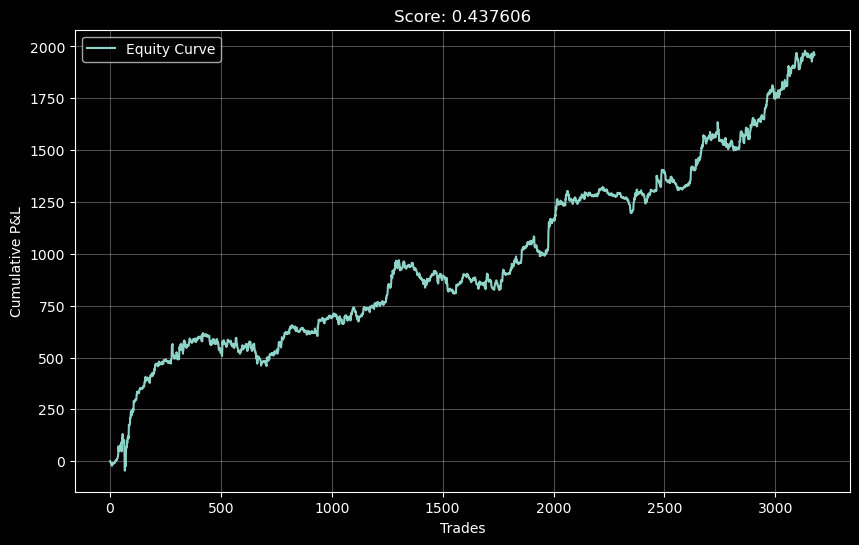

🔍 DEBUG: Tiempo de test in-sample: 0.44 segundos
🔍 DEBUG: Score in-sample: 0.43760576234228243
🔍   DEBUG: Dataset con shape (29580, 31) guardado en /tmp/tmpuhxlpel4.csv
🔍      labels_main value_counts: {0.49255675077438354: 2, 0.520686149597168: 2, 0.6368888020515442: 2, 0.5236639380455017: 2, 0.49378693103790283: 2, 0.60589998960495: 2, 0.537126898765564: 2, 0.4860352873802185: 2, 0.4992152452468872: 2, 0.4456931948661804: 2, 0.39730125665664673: 2, 0.505896806716919: 2, 0.4961754083633423: 2, 0.5046219229698181: 2, 0.41814786195755005: 2, 0.5073463916778564: 2, 0.5806562304496765: 2, 0.4585440158843994: 2, 0.41903358697891235: 2, 0.4709201455116272: 2, 0.5401568412780762: 2, 0.5698442459106445: 2, 0.43600261211395264: 2, 0.45180076360702515: 2, 0.5006138682365417: 2, 0.6665897369384766: 2, 0.48756128549575806: 2, 0.5394609570503235: 2, 0.4748096466064453: 2, 0.660403847694397: 2, 0.4959873557090759: 2, 0.5218071341514587: 2, 0.576517641544342: 2, 0.5627736449241638: 2, 0.464733541011

In [1]:
import optuna
from datetime import datetime
from concurrent.futures import ProcessPoolExecutor, as_completed
from modules.StrategySearcher import StrategySearcher
import warnings
import os
warnings.filterwarnings("ignore")

configs = [
    dict(
        symbol='XAUUSD', timeframe='H1', direction='buy', pruner_type='hyperband',
        train_start=datetime(2020,2,1), train_end=datetime(2025,2,1),
        test_start=datetime(2022,2,1),  test_end=datetime(2023,2,1),
        search_type='reliability', search_subtype='', search_filter='',
        label_method='random', n_models=1, debug=True,
    ),
]

# Crear tag para cada configuración
for cfg in configs:
    # Construir el tag asegurando que no haya dobles guiones bajos por campos vacíos
    tag_parts = [
        cfg['symbol'],
        cfg['timeframe'],
        cfg['direction'],
        cfg['label_method'][:2],
        cfg['search_type'][:3],
        (cfg.get('search_subtype') or '')[:2],
        (cfg.get('search_filter') or '')[:2],
    ]
    # Filtrar partes vacías y unir con "_"
    cfg["tag"] = "_".join([part for part in tag_parts if part]).strip("_")

DB_FILE = f"optuna_dbs/{cfg['tag']}.db"
DB_PATH = f"sqlite:///{DB_FILE}"
STUDY_NAME = f"{cfg['tag']}"

study = None
if not os.path.exists(DB_FILE):
    study = None
else:
    try:
        study = optuna.load_study(study_name=STUDY_NAME, storage=DB_PATH)
    except Exception:
        study = None

n_trials = 5000
if study:
    n_trials = len(study.trials) + n_trials

for cfg in configs:
    cfg['n_trials'] = n_trials

def launch(cfg):
    s = StrategySearcher(**cfg)
    s.run_search()

with ProcessPoolExecutor(max_workers=len(configs)) as pool:
    futures = {pool.submit(launch, c): c["tag"] for c in configs}
    for f in as_completed(futures):
        tag = futures[f]
        try:
            print(f"[{tag}] terminado")
        except Exception as e:
            print(f"[{tag}] falló: {e}")